# Preprocessing: BJH027


This markdown files loads the clean data and does a bipolar rereference as well as epochs the data


In [1]:
import matplotlib
matplotlib.use("Qt5Agg")
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import mat73
import re
from neurodsp.timefrequency import compute_wavelet_transform
from BCI2kReader import BCI2kReader as b2k
import os
import mne
from tabulate import tabulate
import IPython
import seaborn as sns

In [2]:
%matplotlib qt5

In [3]:
## Prep paths ##

subject = 'BJH027'
raw_data_dir = f"/home/brooke/pacman/raw_data/{subject}"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/{subject}/ieeg"

In [4]:
## Load Data ##

# load filtered data #
filtered_clean_fif = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_notched_filtered_clean_ieeg.fif")

# load raw data #
raw_clean_fif = mne.io.Raw(f"{raw_data_dir}/ieeg/{subject}_raw_clean_ieeg.fif")

Opening raw data file /home/brooke/pacman/raw_data/BJH027/ieeg/BJH027_notched_filtered_clean_ieeg.fif...
    Range : 0 ... 2085999 =      0.000 ...  1042.999 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH027/ieeg/BJH027_notched_filtered_clean_ieeg-1.fif...
    Range : 2086000 ... 2983799 =   1043.000 ...  1491.899 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH027/ieeg/BJH027_raw_clean_ieeg.fif...
    Range : 0 ... 2085999 =      0.000 ...  1042.999 secs
Ready.
Opening raw data file /home/brooke/pacman/raw_data/BJH027/ieeg/BJH027_raw_clean_ieeg-1.fif...
    Range : 2086000 ... 2983799 =   1043.000 ...  1491.899 secs
Ready.


### For Kia, pre referencing

In [13]:
# ## Epoching the raw data for Kia - dropping the bad epochs!##

# # load data 
# raw_clean_fif.info['bads'].extend(["FL6",  "FL7"])
# bad_annots = mne.read_annotations('../ieeg/saved_bipolar_cleaning_annotations.fif')   
# raw_clean_fif.set_annotations(bad_annots)
# events = mne.find_events(raw_clean_fif, output='step', consecutive = False, stim_channel='STI')

# # create events
    
# # only epoch good channels
# channels_of_interest =  [x for x in raw_clean_fif.info['ch_names'] if x not in raw_clean_fif.info['bads']]

# # epoch the data
# epoched_data = mne.Epochs(raw_clean_fif, events, 
#                           event_id = 1, tmin = -4, tmax = 10, 
#                           baseline = None, picks = channels_of_interest,
#                              reject_by_annotation = True)
# # save the data
# epoched_data.save(f"{preproc_data_dir}/{subject}_NOREREF_clean_dropped_epochs_pres-locked_ieeg.fif", overwrite = True, split_size = '1.9GB')

480 events found
Event IDs: [0 1]
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
Loading data for 240 events and 28001 original time points ...


/tmp/ipykernel_2915/739118921.py:20: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_NOREREF_clean_dropped_epochs_pres-locked_ieeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data.save(f"{preproc_data_dir}/{subject}_NOREREF_clean_dropped_epochs_pres-locked_ieeg.fif", overwrite = True, split_size = '1.9GB')


95 bad epochs dropped
Loading data for 1 events and 28001 original time points ...
Splitting into 2 parts
Loading data for 73 events and 28001 original time points ...
Loading data for 72 events and 28001 original time points ...


In [14]:
# # epoch the data
# last_away_epochs = mne.Epochs(raw_clean_fif, last_away_events, 
#                           event_id = 1, tmin = -5, tmax =5, 
#                           baseline = None, picks = channels_of_interest,
#                              reject_by_annotation = True)
# # # save the data
# last_away_epochs.save(f"{preproc_data_dir}/{subject}_NOREREF_raw_clean_dropped_epochs_last_away_events.fif", overwrite = True, split_size = '1.9GB')

Not setting metadata
205 matching events found
No baseline correction applied
0 projection items activated
Loading data for 205 events and 20001 original time points ...


/tmp/ipykernel_2915/3952675076.py:7: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_NOREREF_raw_clean_dropped_epochs_last_away_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  last_away_epochs.save(f"{preproc_data_dir}/{subject}_NOREREF_raw_clean_dropped_epochs_last_away_events.fif", overwrite = True, split_size = '1.9GB')


74 bad epochs dropped
Loading data for 1 events and 20001 original time points ...
Splitting into 2 parts
Loading data for 66 events and 20001 original time points ...
Loading data for 65 events and 20001 original time points ...


## Bipolar Rereferencing

In [5]:
# helper functions

def probe_and_num(elec_str): 
    ''' This convenience function takes an electrode string like LHH1 and outputs ('LHH', 1)
    '''
    if '_' in elec_str:
        return None, None
    else:   
        regex_str = '(\D+)(\d+)' # group of letters followed by group of digits
        matcher = re.compile(regex_str,re.IGNORECASE|re.DOTALL).search(elec_str)
        if matcher:
            probe, num = matcher.groups()
            return probe, int(num)
        else:
            return None, None
    
def find_bipolar_pair(ch, labels, remove):
    ''' Find the pair of a given electrode for bipolar referencing.
        Given a single *ch* and a list of *labels*, some of which you want to *remove*,
        this finds the next channel on that probe that isn't meant to be removed (WM is ok).
    '''
    bipolar_pair = None
    probe, num = probe_and_num(ch)
    other_in_probe = [other_ch for other_ch in labels if probe_and_num(other_ch)[0]==probe]
    for i in range(len(other_in_probe)-num):
        next_ch = probe + str(num+i+1)
        if next_ch in remove or next_ch == 'STI':
            continue
        else:
            bipolar_pair = next_ch
            break
    return bipolar_pair

In [6]:
# Here I iterate through the electrodes in my ROIs and match them up with their bipolar pair
pairs = []
anode = []
cathode = []
pairs_name = []
pairs_map = {}
remove = filtered_clean_fif.info['bads']
labels = filtered_clean_fif.info['ch_names']
for ch in labels:
    # if a channel is meant to be removed, it doesn't get to be in a bipolar pair
    if ch in remove or ch == 'STI':
        print(f"{ch} noref")
    else:
        pair = find_bipolar_pair(ch, labels, remove)
        if pair:
            anode.append(ch)
            cathode.append(pair)
            pairs.append((ch, pair))
            pairs_map[ch] = f"{ch}-{pair}"
            pairs_name.append(f"{ch}-{pair}")
            print(ch, pair)

EMPTY noref
EMPTY_2 noref
EMPTY_3 noref
EMPTY_4 noref
REF1 noref
REF2 noref
AL1 AL2
AL2 AL3
AL3 AL4
AL4 AL5
AL5 AL6
AL6 AL7
AL7 AL8
AL8 AL9
AL9 AL10
AL10 AL11
AL11 AL12
AL12 AL13
AL13 AL14
BL1 BL2
BL2 BL3
BL3 BL4
BL4 BL5
BL5 BL6
BL6 BL7
BL7 BL8
BL8 BL9
BL9 BL10
BL10 BL11
BL11 BL12
BL12 BL13
BL13 BL14
BL14 BL15
BL15 BL16
CL1 CL2
CL2 CL3
CL3 CL4
CL4 CL5
CL5 CL6
CL6 CL7
CL7 CL8
CL8 CL9
CL9 CL10
CL10 CL11
CL11 CL12
CL12 CL13
CL13 CL14
CL14 CL15
CL15 CL16
DL1 DL2
DL2 DL3
DL3 DL4
DL4 DL5
DL5 DL6
DL6 DL7
DL7 DL8
DL8 DL9
DL9 DL10
DL10 DL11
DL11 DL12
DL12 DL13
DL13 DL14
DL14 DL15
DL15 DL16
EL1 EL2
EL2 EL3
EL3 EL4
EL4 EL5
EL5 EL6
EL6 EL7
EL7 EL8
EL8 EL9
EL9 EL10
FL1 FL2
FL2 FL3
FL3 FL4
FL4 FL5
FL5 FL6
FL6 FL7
FL8 noref
GL1 GL3
GL2 noref
GL3 GL4
GL4 GL5
GL5 GL6
GL6 GL7
GL7 GL8
GL8 GL12
GL9 noref
GL10 noref
GL11 noref
GL12 GL13
GL13 GL14
HL1 noref
HL2 noref
HL3 noref
HL4 noref
HL5 HL7
HL6 noref
HL7 HL8
HL8 HL9
HL9 HL10
HL10 HL11
HL11 HL12
HL12 HL13
HL13 HL14
HL14 HL15
HL15 HL16
IL1 IL2
IL2 IL3
IL3

In [7]:
## Apply Rereference #

if filtered_clean_fif.info['ch_names'] == raw_clean_fif.info['ch_names'] and filtered_clean_fif.info['bads'] == raw_clean_fif.info['bads']:
    
    # load filtered data
    filtered_clean_fif.load_data()
    
    # set filtered reference 
    bp_filt_fif = mne.set_bipolar_reference(filtered_clean_fif, anode = anode, cathode = cathode)
    
    # save
    bp_filt_fif.save(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif", overwrite = True)
    
    # clear var
    bp_filt_fif = []
    filtered_clean_fif = []
    
    # load raw data
    raw_clean_fif.load_data()
    
    # set raw reference 
    bp_raw_fif = mne.set_bipolar_reference(raw_clean_fif, anode = anode, cathode = cathode)
    
    # save
    bp_raw_fif.save(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif", overwrite = True)

    
    # clear var
    bp_raw_fif = []
    raw_clean_fif = []    
    
    

Reading 0 ... 2983799  =      0.000 ...  1491.899 secs...
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=181, n_times=2983800
    Range : 0 ... 2983799 =      0.000 ...  1491.899 secs
Ready.
Added the following bipolar channels:
AL1-AL2, AL2-AL3, AL3-AL4, AL4-AL5, AL5-AL6, AL6-AL7, AL7-AL8, AL8-AL9, AL9-AL10, AL10-AL11, AL11-AL12, AL12-AL13, AL13-AL14, BL1-BL2, BL2-BL3, BL3-BL4, BL4-BL5, BL5-BL6, BL6-BL7, BL7-BL8, BL8-BL9, BL9-BL10, BL10-BL11, BL11-BL12, BL12-BL13, BL13-BL14, BL14-BL15, BL15-BL16, CL1-CL2, CL2-CL3, CL3-CL4, CL4-CL5, CL5-CL6, CL6-CL7, CL7-CL8, CL8-CL9, CL9-CL10, CL10-CL11, CL11-CL12, CL12-CL13, CL13-CL14, CL14-CL15, CL15-CL16, DL1-DL2, DL2-DL3, DL3-DL4, DL4-DL5, DL5-DL6, DL6-DL7, DL7-DL8, DL8-DL9, DL9-DL10, DL10-DL11, DL11-DL12, DL12-DL13, DL13-DL14, DL14-DL15, DL15-DL16, EL1-EL2, EL2-EL3, EL3-EL4, EL4-EL5, EL5-EL6, EL6-EL7, EL7-EL8, EL8-EL9, EL9-EL10, FL1-FL2, FL2-FL3, FL3-FL4, FL4-FL5, FL5-FL6, FL6-FL7, GL1-GL3, GL3-GL4, 

/tmp/ipykernel_144397/1336304392.py:12: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_filtered_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_filt_fif.save(f"{preproc_data_dir}/{subject}_bp_filtered_clean_data.fif", overwrite = True)


Overwriting existing file.
Writing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_filtered_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_filtered_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_filtered_clean_data.fif
[done]
Reading 0 ... 2983799  =      0.000 ...  1491.899 secs...
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=181, n_times=2983800
    Range : 0 ... 2983799 =      0.000 ...  1491.899 secs
Ready.
Added the following bipolar channels:
AL1-AL2, AL2-AL3, AL3-AL4, AL4-AL5, AL5-AL6, AL6-AL7, AL7-AL8, AL8-AL9, AL9-AL10, AL10-AL11, AL11-AL12, AL12-AL13, AL13-AL14, BL1-BL2, BL2-BL3, BL3-BL4, BL4-BL5, BL5-BL6, BL6-BL7, BL7-BL8, BL8-BL9, BL9-BL10, BL10-BL11, BL11-BL12, BL12-BL13, BL13-BL14, BL14-BL15, BL15-BL16, CL1-CL2, CL2-CL3, CL3-CL4, CL4-CL5, CL5-CL6, CL6-CL7, CL7-CL8, CL8-CL9, CL9-CL10, CL10-CL11, CL11-CL12, CL12-CL13, CL13-CL14, CL14-CL15, CL15-CL16, 

/tmp/ipykernel_144397/1336304392.py:25: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_raw_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_raw_fif.save(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif", overwrite = True)


Overwriting existing file.
Writing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_raw_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_raw_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_raw_clean_data.fif
[done]


## For Kia 

In [5]:
# ## Apply WM Rereference #

# channel_csv = pd.read_csv(f"{preproc_data_dir}/../BJH027_wm_referencing.csv")
# anode_full = channel_csv['anode'].tolist()
# cathode_full = channel_csv['cathode'].tolist()


# anode = [anode_full[x] for x in range(len(anode_full)) if cathode_full[x] != 'noref'] 
# cathode = [cathode_full[x] for x in range(len(cathode_full)) if cathode_full[x] != 'noref'] 

# if filtered_clean_fif.info['ch_names'] == raw_clean_fif.info['ch_names'] and filtered_clean_fif.info['bads'] == raw_clean_fif.info['bads']:
    
#     # load filtered data
#     filtered_clean_fif.load_data()
    
#     # set filtered reference 
#     bp_filt_fif = mne.set_bipolar_reference(filtered_clean_fif, anode = anode, cathode = cathode)
    
#     # save
#     bp_filt_fif.save(f"{preproc_data_dir}/{subject}_WM_filtered_clean_data.fif", overwrite = True)
    
#     # clear var
#     bp_filt_fif = []
#     filtered_clean_fif = []
    
#     # load raw data
#     raw_clean_fif.load_data()
    
#     # set raw reference 
#     bp_raw_fif = mne.set_bipolar_reference(raw_clean_fif, anode = anode, cathode = cathode)
    
#     # save
#     bp_raw_fif.save(f"{preproc_data_dir}/{subject}_WM_raw_clean_data.fif", overwrite = True)

    
#     # clear var
#     bp_raw_fif = []
#     raw_clean_fif = []   

Reading 0 ... 2983799  =      0.000 ...  1491.899 secs...
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=141, n_times=2983800
    Range : 0 ... 2983799 =      0.000 ...  1491.899 secs
Ready.
Added the following bipolar channels:
BL1-BL10, BL2-BL10, BL3-BL10, BL4-BL10, BL5-BL10, BL6-BL10, BL7-BL10, BL8-BL10, BL9-BL10, BL12-BL11, BL13-BL11, BL14-BL11, BL15-BL11, BL16-BL11, CL1-CL3, CL2-CL3, CL4-CL3, CL5-CL3, CL6-CL8, CL7-CL8, CL9-CL8, CL10-CL8, CL11-CL8, CL12-CL8, CL13-CL8, CL14-CL8, CL15-CL8, CL16-CL8, DL1-DL4, DL2-DL4, DL3-DL4, DL12-DL11, DL13-DL11, DL14-DL11, DL15-DL11, DL16-DL11, GL1-GL5, GL2-GL5, GL3-GL5, GL4-GL5, GL6-GL5, GL7-GL5, GL8-GL5, GL9-GL5, GL10-GL5, GL11-GL5, GL12-GL5, GL13-GL5, GL14-GL5, HL1-HL6, HL2-HL6, HL3-HL6, HL4-HL6, HL5-HL6, HL7-HL6, HL8-HL10, HL9-HL10, HL11-HL10, HL12-HL10, HL13-HL10, HL14-HL10, HL15-HL10, HL16-HL10, JL1-JL5, JL2-JL5, JL3-JL5, JL4-JL5, JL8-JL7, KL1-KL11, KL2-KL11, KL3-KL11, KL4-KL11, KL5-KL11, KL6-KL1

/tmp/ipykernel_2915/3007223534.py:17: RuntimeWarning: Bipolar channels are based on bad channels: ['GL2-GL5', 'GL9-GL5', 'GL10-GL5', 'GL11-GL5', 'HL1-HL6', 'HL2-HL6', 'HL3-HL6', 'HL4-HL6', 'HL5-HL6', 'HL7-HL6', 'JL1-JL5', 'KL1-KL11', 'HR1-HR8', 'HR2-HR8', 'HR3-HR8', 'HR4-HR8', 'HR5-HR8'].
  bp_filt_fif = mne.set_bipolar_reference(filtered_clean_fif, anode = anode, cathode = cathode)


Writing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_WM_filtered_clean_data.fif


/tmp/ipykernel_2915/3007223534.py:20: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_WM_filtered_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_filt_fif.save(f"{preproc_data_dir}/{subject}_WM_filtered_clean_data.fif", overwrite = True)


Overwriting existing file.
Writing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_WM_filtered_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_WM_filtered_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_WM_filtered_clean_data.fif
[done]
Reading 0 ... 2983799  =      0.000 ...  1491.899 secs...
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=141, n_times=2983800
    Range : 0 ... 2983799 =      0.000 ...  1491.899 secs
Ready.
Added the following bipolar channels:
BL1-BL10, BL2-BL10, BL3-BL10, BL4-BL10, BL5-BL10, BL6-BL10, BL7-BL10, BL8-BL10, BL9-BL10, BL12-BL11, BL13-BL11, BL14-BL11, BL15-BL11, BL16-BL11, CL1-CL3, CL2-CL3, CL4-CL3, CL5-CL3, CL6-CL8, CL7-CL8, CL9-CL8, CL10-CL8, CL11-CL8, CL12-CL8, CL13-CL8, CL14-CL8, CL15-CL8, CL16-CL8, DL1-DL4, DL2-DL4, DL3-DL4, DL12-DL11, DL13-DL11, DL14-DL11, DL15-DL11, DL16-DL11, GL1-GL5, GL2-GL5, GL3-GL5, GL4-GL5, GL6-GL5, GL7-GL5, GL8-GL5,

/tmp/ipykernel_2915/3007223534.py:30: RuntimeWarning: Bipolar channels are based on bad channels: ['GL2-GL5', 'GL9-GL5', 'GL10-GL5', 'GL11-GL5', 'HL1-HL6', 'HL2-HL6', 'HL3-HL6', 'HL4-HL6', 'HL5-HL6', 'HL7-HL6', 'JL1-JL5', 'KL1-KL11', 'HR1-HR8', 'HR2-HR8', 'HR3-HR8', 'HR4-HR8', 'HR5-HR8'].
  bp_raw_fif = mne.set_bipolar_reference(raw_clean_fif, anode = anode, cathode = cathode)


Writing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_WM_raw_clean_data.fif


/tmp/ipykernel_2915/3007223534.py:33: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_WM_raw_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_raw_fif.save(f"{preproc_data_dir}/{subject}_WM_raw_clean_data.fif", overwrite = True)


Overwriting existing file.
Writing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_WM_raw_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_WM_raw_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_WM_raw_clean_data.fif
[done]


In [4]:
# ## Apply CAR Rereference #

# if filtered_clean_fif.info['ch_names'] == raw_clean_fif.info['ch_names'] and filtered_clean_fif.info['bads'] == raw_clean_fif.info['bads']:
    
#     # load filtered data
#     filtered_clean_fif.load_data()
    
#     # set filtered reference 
#     bp_filt_fif = mne.set_eeg_reference(filtered_clean_fif, ref_channels='average')[0]
    
#     # save
#     bp_filt_fif.save(f"{preproc_data_dir}/{subject}_CAR_filtered_clean_data.fif", overwrite = True)
    
#     # clear var
#     bp_filt_fif = []
#     filtered_clean_fif = []
    
#     # load raw data
#     raw_clean_fif.load_data()
    
#     # set raw reference 
#     bp_raw_fif = mne.set_eeg_reference(raw_clean_fif, ref_channels='average')[0]
    
#     # save
#     bp_raw_fif.save(f"{preproc_data_dir}/{subject}_CAR_raw_clean_data.fif", overwrite = True)

    
#     # clear var
#     bp_raw_fif = []
#     raw_clean_fif = []    
    
    

Reading 0 ... 2983799  =      0.000 ...  1491.899 secs...
sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.
Writing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_CAR_filtered_clean_data.fif


/tmp/ipykernel_4138025/3866267793.py:12: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_CAR_filtered_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_filt_fif.save(f"{preproc_data_dir}/{subject}_CAR_filtered_clean_data.fif", overwrite = True)


Overwriting existing file.
Writing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_CAR_filtered_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_CAR_filtered_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_CAR_filtered_clean_data.fif
[done]
Reading 0 ... 2983799  =      0.000 ...  1491.899 secs...
sEEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('sEEG',) reference.
Writing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_CAR_raw_clean_data.fif


/tmp/ipykernel_4138025/3866267793.py:25: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_CAR_raw_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_raw_fif.save(f"{preproc_data_dir}/{subject}_CAR_raw_clean_data.fif", overwrite = True)


Overwriting existing file.
Writing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_CAR_raw_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_CAR_raw_clean_data-1.fif
Closing /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_CAR_raw_clean_data.fif
[done]


Using matplotlib as 2D backend.


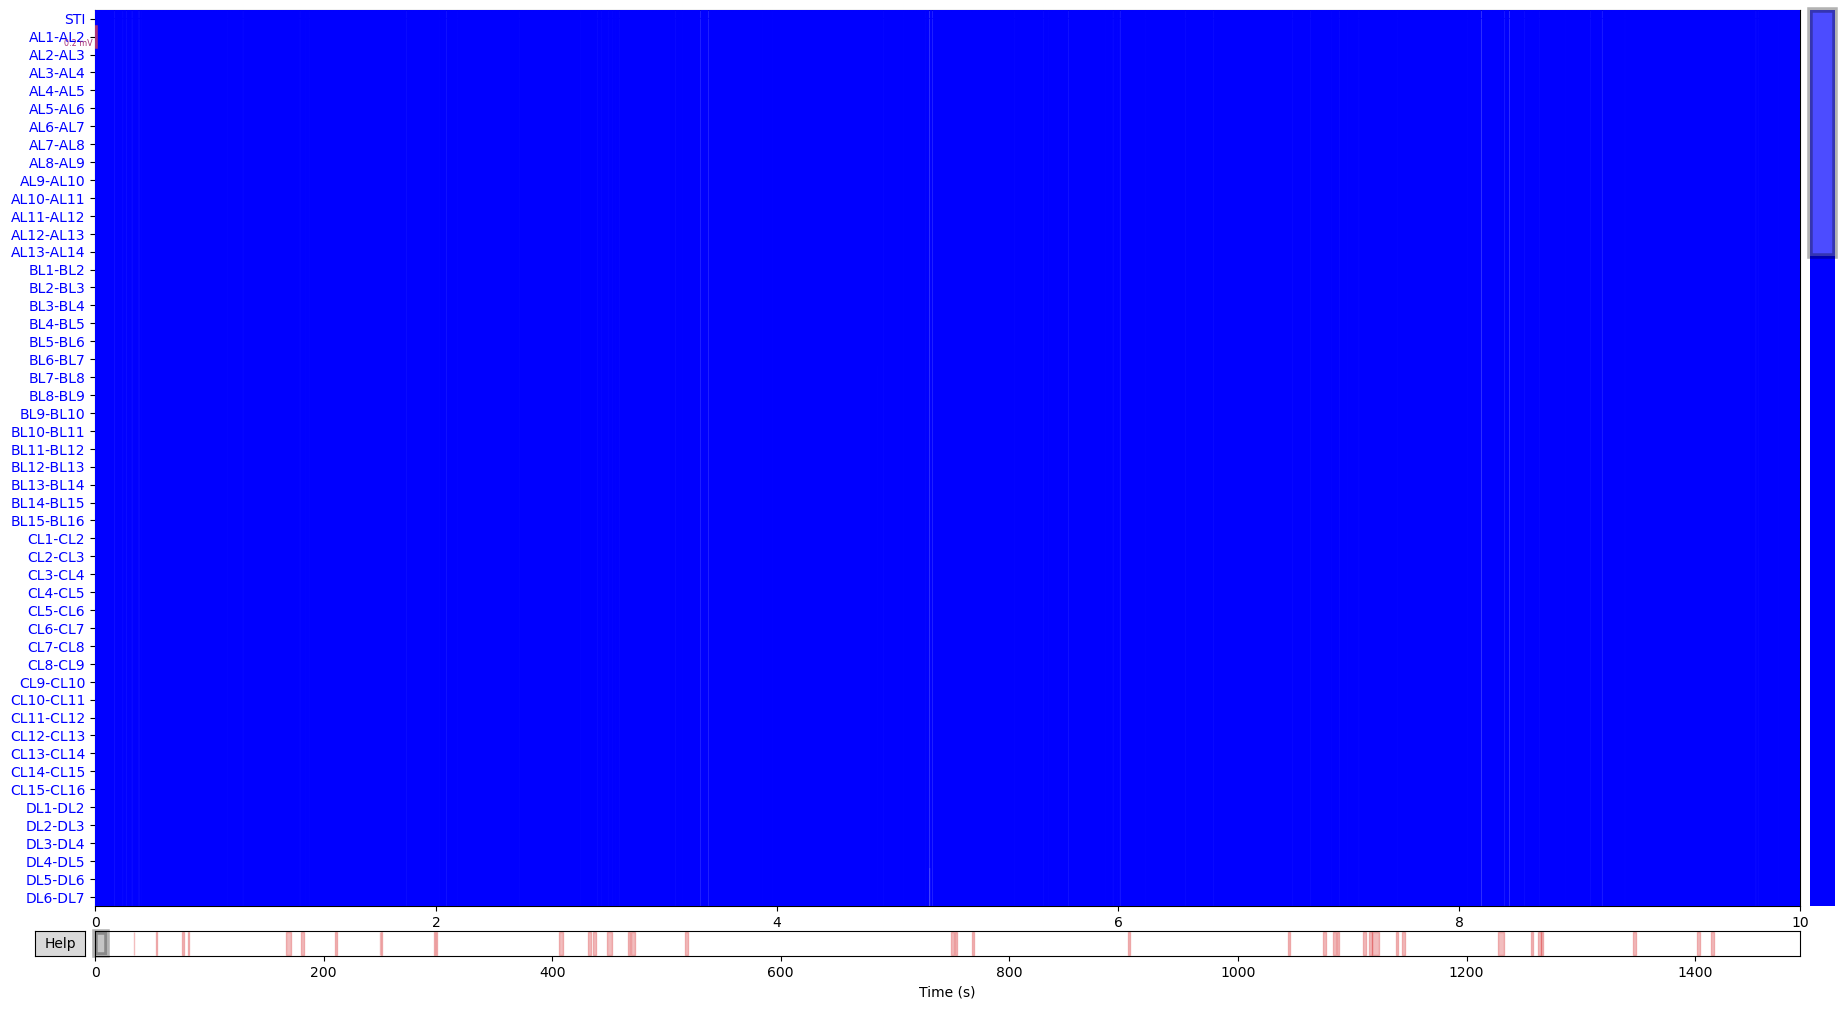

In [6]:
# Visualize it #

bp_raw_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif")
events = mne.find_events(bp_raw_fif, output='step', consecutive = False, stim_channel='STI')

bp_raw_fif.drop_channels(bp_raw_fif.info['bads'])
bp_raw_fif.plot(events=events, color='b', bad_color = 'cyan', n_channels = 50, clipping = None, event_color = 'r')

In [7]:
# add bad channel FL6-FL7

Channels marked as bad:
['FL6-FL7']


In [8]:
# From interactive sessions
interactive_annot = bp_raw_fif.annotations
for x in range(0, len(bp_raw_fif.annotations)):
    print(interactive_annot[x])
    
bp_raw_fif.annotations.save('../ieeg/saved_bipolar_cleaning_annotations.fif', overwrite = True)        

OrderedDict([('onset', 33.747841), ('duration', 0.5715827941894531), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 53.189335), ('duration', 0.6636009216308594), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 75.686996), ('duration', 2.199005126953125), ('description', 'bad'), ('orig_time', None)])
OrderedDict([('onset', 81.30397), ('duration', 0.9767913818359375), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 167.154037), ('duration', 3.8839569091796875), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 179.843002), ('duration', 2.6880035400390625), ('description', 'bad'), ('orig_time', None)])
OrderedDict([('onset', 209.884003), ('duration', 1.7610015869140625), ('description', 'bad'), ('orig_time', None)])
OrderedDict([('onset', 248.965286), ('duration', 0.0), ('description', 'BAD_'), ('orig_time', None)])
OrderedDict([('onset', 250.322281), ('duration', 1.147125244140625), ('description', 'BA

/tmp/ipykernel_7087/2074103935.py:6: RuntimeWarning: This filename (../ieeg/saved_bipolar_cleaning_annotations.fif) does not conform to MNE naming conventions. All annotations files should end with -annot.fif, -annot.fif.gz, _annot.fif, _annot.fif.gz, .txt or .csv
  bp_raw_fif.annotations.save('../ieeg/saved_bipolar_cleaning_annotations.fif', overwrite = True)


## Epoching the data 

In [31]:
## Epoching the raw data ##

# load data 
bp_raw_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif")
events = mne.find_events(bp_raw_fif, output='step', consecutive = False, stim_channel='STI')

# create events
    
# only epoch good channels
channels_of_interest =  [x for x in bp_raw_fif.info['ch_names'] if x not in bp_raw_fif.info['bads']]

# epoch the data
epoched_data = mne.Epochs(bp_raw_fif, events, 
                          event_id = 1, tmin = -4, tmax = 10, 
                          baseline = None, picks = channels_of_interest,
                             reject_by_annotation = True)
# save the data
epoched_data.save(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_tmp_ieeg.fif", overwrite = True, split_size = '1.9GB')

Opening raw data file /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_raw_clean_data.fif...
    Range : 0 ... 2225999 =      0.000 ...  1112.999 secs
Ready.
Opening raw data file /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_raw_clean_data-1.fif...
    Range : 2226000 ... 2983799 =   1113.000 ...  1491.899 secs
Ready.


/tmp/ipykernel_7087/734796667.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_raw_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_raw_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_bp_raw_clean_data.fif")


480 events found
Event IDs: [0 1]
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
Loading data for 240 events and 28001 original time points ...


/tmp/ipykernel_7087/734796667.py:18: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_bp_clean_pres-locked_tmp_ieeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data.save(f"{preproc_data_dir}/{subject}_bp_clean_pres-locked_tmp_ieeg.fif", overwrite = True, split_size = '1.9GB')


86 bad epochs dropped
Loading data for 1 events and 28001 original time points ...
Splitting into 2 parts
Loading data for 77 events and 28001 original time points ...
Loading data for 77 events and 28001 original time points ...


In [30]:
good_epochs = [i for i,x in enumerate(epoched_data.get_annotations_per_epoch()) if not x]
len(good_epochs)

154

In [5]:
## Epoching the raw data for Kia - dropping the bad epochs!##

# load data 
bp_raw_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_CAR_raw_clean_data.fif")
bp_raw_fif.info['bads'].extend(['FL6', 'FL7'])
events = mne.find_events(bp_raw_fif, output='step', consecutive = False, stim_channel='STI')

# create events
    
# only epoch good channels
channels_of_interest =  [x for x in bp_raw_fif.info['ch_names'] if x not in bp_raw_fif.info['bads']]

# epoch the data
epoched_data = mne.Epochs(bp_raw_fif, events, 
                          event_id = 1, tmin = -4, tmax = 10, 
                          baseline = None, picks = channels_of_interest,
                             reject_by_annotation = True)
# save the data
epoched_data.save(f"{preproc_data_dir}/{subject}_CAR_clean_dropped_epochs_pres-locked_ieeg.fif", overwrite = True, split_size = '1.9GB')

Opening raw data file /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_CAR_raw_clean_data.fif...
    Range : 0 ... 2085999 =      0.000 ...  1042.999 secs
Ready.
Opening raw data file /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_CAR_raw_clean_data-1.fif...
    Range : 2086000 ... 2983799 =   1043.000 ...  1491.899 secs
Ready.


/tmp/ipykernel_4138025/2860935122.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_CAR_raw_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_raw_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_CAR_raw_clean_data.fif")


480 events found
Event IDs: [0 1]
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
Loading data for 240 events and 28001 original time points ...


/tmp/ipykernel_4138025/2860935122.py:19: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_CAR_clean_dropped_epochs_pres-locked_ieeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data.save(f"{preproc_data_dir}/{subject}_CAR_clean_dropped_epochs_pres-locked_ieeg.fif", overwrite = True, split_size = '1.9GB')


86 bad epochs dropped
Loading data for 1 events and 28001 original time points ...
Splitting into 2 parts
Loading data for 77 events and 28001 original time points ...
Loading data for 77 events and 28001 original time points ...


In [7]:
## Epoching the raw data for Kia - dropping the bad epochs!##

# load data 
bp_raw_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_WM_raw_clean_data.fif")
bp_raw_fif.info['bads'].extend(["FL6",  "FL7"])
bad_annots = mne.read_annotations('../ieeg/saved_bipolar_cleaning_annotations.fif')   
bp_raw_fif.set_annotations(bad_annots)


events = mne.find_events(bp_raw_fif, output='step', consecutive = False, stim_channel='STI')

# create events
    
# only epoch good channels
channels_of_interest =  [x for x in bp_raw_fif.info['ch_names'] if x not in bp_raw_fif.info['bads']]

# epoch the data
epoched_data = mne.Epochs(bp_raw_fif, events, 
                          event_id = 1, tmin = -4, tmax = 10, 
                          baseline = None, picks = channels_of_interest,
                             reject_by_annotation = True)

# save the data
epoched_data.save(f"{preproc_data_dir}/{subject}_WM_clean_dropped_epochs_pres-locked_ieeg.fif", overwrite = True, split_size = '1.9GB')

Opening raw data file /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_WM_raw_clean_data.fif...
    Range : 0 ... 2271999 =      0.000 ...  1135.999 secs
Ready.
Opening raw data file /home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_WM_raw_clean_data-1.fif...
    Range : 2272000 ... 2983799 =   1136.000 ...  1491.899 secs
Ready.


/tmp/ipykernel_2915/3466355087.py:4: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_WM_raw_clean_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  bp_raw_fif = mne.io.Raw(f"{preproc_data_dir}/{subject}_WM_raw_clean_data.fif")


480 events found
Event IDs: [0 1]
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
Loading data for 240 events and 28001 original time points ...


/tmp/ipykernel_2915/3466355087.py:24: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_WM_clean_dropped_epochs_pres-locked_ieeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data.save(f"{preproc_data_dir}/{subject}_WM_clean_dropped_epochs_pres-locked_ieeg.fif", overwrite = True, split_size = '1.9GB')


95 bad epochs dropped
Loading data for 1 events and 28001 original time points ...
Splitting into 2 parts
Loading data for 73 events and 28001 original time points ...
Loading data for 72 events and 28001 original time points ...


## Last Away

In [8]:
## Load Behavioral Data ##
last_away_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_last_away_events.csv")
last_away_data

,neural_trial_numeric,TrialType,sample,sample_before,event
0,0,7,45300,0,1
1,1,6,56300,0,1
2,2,11,68400,0,1
3,3,5,83800,0,1
4,4,9,96200,0,1
...,...,...,...,...,...
200,234,14,2815300,0,1
201,235,8,2825700,0,1
202,236,18,2836100,0,1
203,237,19,2848000,0,1


In [9]:
# create events
last_away_events = last_away_data[['sample', 'sample_before', 'event']].copy().to_numpy()


In [15]:
# epoch the data
last_away_epochs = mne.Epochs(bp_raw_fif, last_away_events, 
                          event_id = 1, tmin = -5, tmax =5, 
                          baseline = None, picks = channels_of_interest,
                             reject_by_annotation = False)
# # save the data
last_away_epochs.save(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_away_events.fif", overwrite = True, split_size = '1.9GB')


Not setting metadata
205 matching events found
No baseline correction applied
0 projection items activated


In [8]:
# epoch the data
last_away_epochs = mne.Epochs(bp_raw_fif, last_away_events, 
                          event_id = 1, tmin = -5, tmax =5, 
                          baseline = None, picks = channels_of_interest,
                             reject_by_annotation = True)
# # save the data
last_away_epochs.save(f"{preproc_data_dir}/{subject}_CAR_raw_clean_dropped_epochs_last_away_events.fif", overwrite = True, split_size = '1.9GB')

Not setting metadata
205 matching events found
No baseline correction applied
0 projection items activated
Loading data for 205 events and 20001 original time points ...


/tmp/ipykernel_4138025/3550890125.py:7: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_CAR_raw_clean_dropped_epochs_last_away_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  last_away_epochs.save(f"{preproc_data_dir}/{subject}_CAR_raw_clean_dropped_epochs_last_away_events.fif", overwrite = True, split_size = '1.9GB')


66 bad epochs dropped
Loading data for 1 events and 20001 original time points ...
Splitting into 2 parts
Loading data for 70 events and 20001 original time points ...
Loading data for 69 events and 20001 original time points ...


In [10]:
# epoch the data
last_away_epochs = mne.Epochs(bp_raw_fif, last_away_events, 
                          event_id = 1, tmin = -5, tmax =5, 
                          baseline = None, picks = channels_of_interest,
                             reject_by_annotation = True)
# # save the data
last_away_epochs.save(f"{preproc_data_dir}/{subject}_WM_raw_clean_dropped_epochs_last_away_events.fif", overwrite = True, split_size = '1.9GB')

Not setting metadata
205 matching events found
No baseline correction applied
0 projection items activated
Loading data for 205 events and 20001 original time points ...


/tmp/ipykernel_2915/374148344.py:7: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing/BJH027/ieeg/BJH027_WM_raw_clean_dropped_epochs_last_away_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  last_away_epochs.save(f"{preproc_data_dir}/{subject}_WM_raw_clean_dropped_epochs_last_away_events.fif", overwrite = True, split_size = '1.9GB')


74 bad epochs dropped
Loading data for 1 events and 20001 original time points ...
Loading data for 131 events and 20001 original time points ...


## Last Dot

In [ ]:
## Load Behavioral Data ##
last_dot_data = pd.read_csv(f"{raw_data_dir}/behave/{subject}_last_dot_events.csv")
last_dot_data

In [ ]:
# filter to good epochs and fix trial indexing
last_dot_data['trial_numeric'] = last_dot_data['trial_numeric'] - 1

# create events
last_dot_events = last_dot_data[['sample', 'sample_before', 'event']].copy().to_numpy()


In [ ]:
# epoch the data
last_dot_epochs = mne.Epochs(bp_raw_fif, last_dot_events, 
                          event_id = 1, tmin = -.75 * 4, tmax =.75 * 3, 
                          baseline = None, picks = channels_of_interest,
                             reject_by_annotation = False)
# # save the data
last_dot_epochs.save(f"{preproc_data_dir}/{subject}_bp_raw_clean_last_dot_events.fif", overwrite = True, split_size = '1.9GB')
